### Suleimenova Madina

### Exercise 2: Time Series Analysis


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('C:\\Users\\sulej\\OneDrive\\Рабочий стол\\7 semester\\Data Mining\\train.csv', parse_dates=['date'], index_col='date')
print(df.head())
print(df.info())

# I needed to do some preprocessing stuff like:
# choose data for one store and one item so analysis will be more focused
data = df[(df['store'] == 1) & (df['item'] == 1)]
data = data[['sales']]
data = data.asfreq('D')  # Set to daily frequency
print(data.head())


            store  item  sales
date                          
2013-01-01      1     1     13
2013-01-02      1     1     11
2013-01-03      1     1     14
2013-01-04      1     1     13
2013-01-05      1     1     10
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB
None
            sales
date             
2013-01-01     13
2013-01-02     11
2013-01-03     14
2013-01-04     13
2013-01-05     10


In [3]:
# Check for missing values
# I decided to use interpolate function because it fiils data linearly 
data['sales'] = data['sales'].interpolate(method='linear')

# Check fo Na values
print(data.isnull().sum())


sales    0
dtype: int64


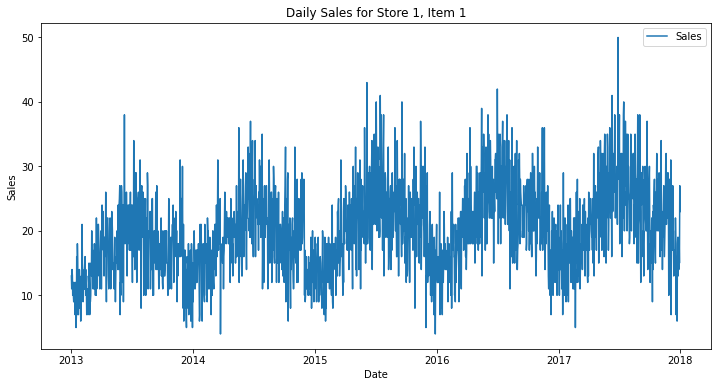

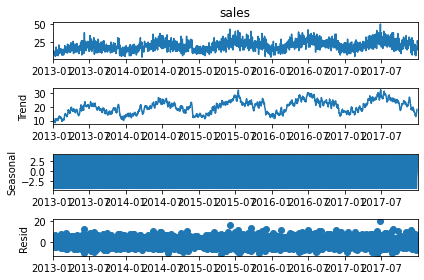

In [4]:
# Line plot to visualize the time series data
plt.figure(figsize=(12, 6))
plt.plot(data['sales'], label='Sales')
plt.title('Daily Sales for Store 1, Item 1')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Decompose the time series into trend, seasonality, and residuals
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['sales'], model='additive')
decomposition.plot()
plt.show()


In [5]:
from statsmodels.tsa.arima.model import ARIMA

#The ARIMA model predicts future values of a time series by analyzing its past values (AutoRegression) and 
#past errors (Moving Average) while ensuring the series is stationary by removing trends (Integration).

# Example:
# Day   Sales
#1     100
#2     110
#3     120
#4     130

# Difference = [110-100, 120-110, 130-120] = [10, 10, 10]

#Step 2: Fit AR (AutoRegression)
#AR finds relationships between past and current values.
#Example: "Today's sales = 0.8 × Yesterday's sales + Error."

#Step 3: Fit MA (Moving Average)
#MA uses the errors from past predictions to adjust the forecast.
#Example: "If yesterday's prediction underestimated by 10, today's prediction adds a correction."

#Step 4: Combine AR, I, and MA
#ARIMA combines these steps to create a formula like:
#"Sales = 0.8 × Yesterday's Sales + Past Error + Random Noise."

# Define and fit the ARIMA model
arima_model = ARIMA(data['sales'], order=(1, 1, 1))  # Adjust p, d, q as needed based on ACF/PACF plots
arima_fit = arima_model.fit()
data['ARIMA_Predictions'] = arima_fit.predict(start=0, end=len(data) - 1, typ="levels")


In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#The Holt-Winters model predicts future values of a time series by combining three components:
#Level: The base value of the series (e.g., average sales).
#Trend: How the series increases or decreases over time (e.g., steady sales growth).
#Seasonality: Repeating patterns at regular intervals (e.g., higher sales during holidays).
####It works well for time series data with trend and seasonality.
# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(data['sales'], trend='add', seasonal='add', seasonal_periods=365)
hw_fit = hw_model.fit()
data['HW_Predictions'] = hw_fit.fittedvalues


In [7]:
# Load the test set
test_df = pd.read_csv('C:\\Users\\sulej\\OneDrive\\Рабочий стол\\7 semester\\Data Mining\\test.csv', parse_dates=['date'], index_col='date')

# Filter the test set for store 1, item 1 (or any other specific combination)
test_data = test_df[(test_df['store'] == 1) & (test_df['item'] == 1)]

# Generate predictions using ARIMA model on the dates in the test set
arima_predictions = arima_fit.predict(start=test_data.index[0], end=test_data.index[-1], typ="levels")

# Generate predictions using Holt-Winters model for the test period
hw_predictions = hw_fit.forecast(steps=len(test_data))

# If we don’t have actual 'sales' values in the test set, we can output predictions directly
test_data['ARIMA_Predictions'] = arima_predictions
test_data['HW_Predictions'] = hw_predictions

# Display predictions
print(test_data[['ARIMA_Predictions', 'HW_Predictions']])


            ARIMA_Predictions  HW_Predictions
date                                         
2018-01-01          18.088292       18.758138
2018-01-02          17.731649       17.157220
2018-01-03          17.705753       17.333852
2018-01-04          17.703872       17.333984
2018-01-05          17.703736       16.512239
...                       ...             ...
2018-03-27          17.703725       21.521645
2018-03-28          17.703725       21.328209
2018-03-29          17.703725       20.957469
2018-03-30          17.703725       21.388006
2018-03-31          17.703725       20.364630

[90 rows x 2 columns]


C:\Users\sulej\AppData\Local\Temp\ipykernel_9200\661694372.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARIMA_Predictions'] = arima_predictions
C:\Users\sulej\AppData\Local\Temp\ipykernel_9200\661694372.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['HW_Predictions'] = hw_predictions


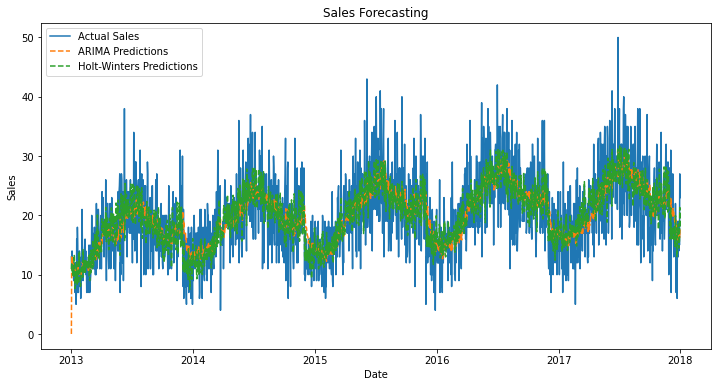

In [8]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(data['sales'], label='Actual Sales')
plt.plot(data['ARIMA_Predictions'], label='ARIMA Predictions', linestyle='--')
plt.plot(data['HW_Predictions'], label='Holt-Winters Predictions', linestyle='--')
plt.title('Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()
